# Automatic Essay Scoring (AES)

Automatic Essay Scoring (AES) é uma tarefa de machine learning que consistem em atribuir uma nota para redação de maneira automática.
No geral, diversas abordagens na literatura apresentaram resultados significativos na tentativa de realizar esse processo utilizando diversas técnicas e algoritmos focando em diferentes aspectos como analise da corretude gramatical, existência de estrutura retórica entre outras.

Essencialmente, AES consiste em duas principais abordagens, a primeira usa regressão para atribuir uma nota ao texto de entrada, enquanto a segunda tenta classificar a nota em um intervalo predeterminado e fixo, por exemplo, (e.g 0, 50, 100, 150, 200) . Além disso,  podemos ainda dividir as notas por rubricas, aspectos especificos do texto que são avaliados como, por exemplo, apenas a gramatica, ou apenas a argumentação do texto etc.

Nesse contexto, a correção automática de redações do ENEM, por exemplo, tem sido tema de diversos artigos da área que empregam uma diversidade de técnicas com esse fim. Um dos objetivos para isso é a redução do tempo de correção e do custo operacional para isso. Assim, várias artigos, diversas técnicas foram empregadas, tanto aquelas que buscam uma classificação holistica (classificação da nota final) como aquelas que buscam uma classificação por rúbrica (classificação de um aspecto especifico).


Dessa maneira, nesse trabalho, para fins de simplicidade, iremos aplicar técnicas de classificação da nota final de redações do enem. Utilizaremos para isso o conjunto de dados de redações do UOL que contém 4570 redações em diferentes assuntos. Para atribuir uma nota, iremos utilizar um conjunto de classificadores extraindo diversas características relacionadas as aspectos como legibilidade, coesão, coerência e outros para assim classificar a nota entre 0, 50, 100, 150 e 200.



## Carregando o Conjunto de Dados


Nessa etapa, carregamos o conjunto de dados utilizando a biblioteca aibox-nlp que conta com diversos conjuntos de dados relacionados redação do ENEM, bem como, pipelines para extração de caracteríticas (features em inglês).

In [1]:
from aibox.nlp.data.datasets import DatasetEssayBR, DatasetPortugueseNarrativeEssays

N_SAMPLE = 500
# === Essay-BR ===
ds = DatasetEssayBR(extended=False,
                    target_competence='score')
df_dataset = ds.to_frame().sample(n=N_SAMPLE)
df_dataset

/opt/conda/envs/aibox-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,text,target,C1,C2,C3,C4,C5,score,prompt
733,Com uma educação de qualidade e disciplina exe...,440,80,120,80,80,80,440,Os colégios militares de vários Estados do Bra...
2314,"Em meados de 1500, o mundo passava pela transi...",720,160,160,120,160,120,720,Segundo a resolução Conama Nº001 de janeiro de...
3458,"Produzida na década de 30, Gloomy Sunday ( Dom...",680,120,160,120,160,120,680,O suicídio pode ser causado por vários fatores...
1315,"Não há como negar que, desde os primórdios , a...",520,120,120,80,120,80,520,A presença dos índios no território brasileiro...
3260,O uso de agrotóxicos no Brasil é um tema que e...,400,120,80,80,80,40,400,Os agrotóxicos são produtos utilizados na agri...
...,...,...,...,...,...,...,...,...,...
153,O avanço tecnológico que ajudou a muitos com a...,520,120,120,80,80,120,520,"Há cerca de dez anos, as redes sociais se torn..."
2444,"A Reforma da previdência, uma nova mudança no ...",600,120,160,120,120,80,600,"Reforma da Previdência Social, ou simplesmente..."
2539,A sociedade atualmente enfrenta uma grande bat...,600,120,120,120,120,120,600,"As Doenças Sexualmente Transmissíveis, ou DSTs..."
438,Recentemente há uma discussão que está em anda...,440,120,80,80,80,80,440,"No início deste mês de novembro, o Supremo Tri..."


<Axes: xlabel='target'>

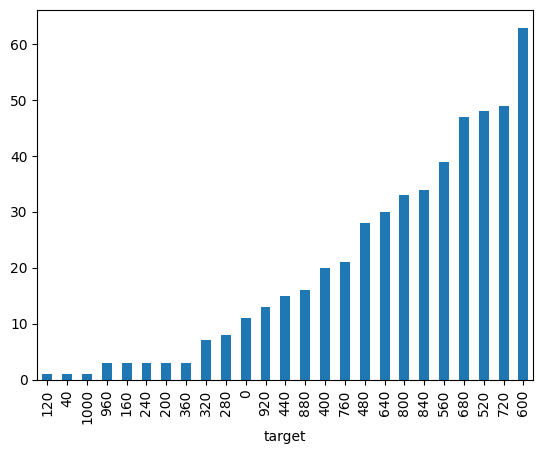

In [2]:
df_dataset.target.value_counts().sort_values().plot(kind="bar")

In [3]:
import numpy as np

count_values = df_dataset.target.value_counts()
low_counts =  count_values >= 6

filtered_df = df_dataset[np.isin(df_dataset.score, count_values[low_counts].index)]
filtered_df

,text,target,C1,C2,C3,C4,C5,score,prompt
733,Com uma educação de qualidade e disciplina exe...,440,80,120,80,80,80,440,Os colégios militares de vários Estados do Bra...
2314,"Em meados de 1500, o mundo passava pela transi...",720,160,160,120,160,120,720,Segundo a resolução Conama Nº001 de janeiro de...
3458,"Produzida na década de 30, Gloomy Sunday ( Dom...",680,120,160,120,160,120,680,O suicídio pode ser causado por vários fatores...
1315,"Não há como negar que, desde os primórdios , a...",520,120,120,80,120,80,520,A presença dos índios no território brasileiro...
3260,O uso de agrotóxicos no Brasil é um tema que e...,400,120,80,80,80,40,400,Os agrotóxicos são produtos utilizados na agri...
...,...,...,...,...,...,...,...,...,...
153,O avanço tecnológico que ajudou a muitos com a...,520,120,120,80,80,120,520,"Há cerca de dez anos, as redes sociais se torn..."
2444,"A Reforma da previdência, uma nova mudança no ...",600,120,160,120,120,80,600,"Reforma da Previdência Social, ou simplesmente..."
2539,A sociedade atualmente enfrenta uma grande bat...,600,120,120,120,120,120,600,"As Doenças Sexualmente Transmissíveis, ou DSTs..."
438,Recentemente há uma discussão que está em anda...,440,120,80,80,80,80,440,"No início deste mês de novembro, o Supremo Tri..."


In [4]:
Y = filtered_df.loc[:, 'score'] / 1000

## Treinando o Modelo

### Extração de Características


Como abordado em diversos artigos, uma forma de realizar a classificação de redação é usando extração de características do texto.

In [5]:
import json

from aibox.nlp.factory import get_extractor

In [6]:
FEATURES_lIST = ['readabilityBR',
                  'regencyBR',
                  'syntacticComplexityBR',
                  'textualSimplicityBR']

TEXT_EXEMPLE = "O poeta modernista Oswald de Andrade relata, em \"Erro de Português\", que, sob um dia de chuva, o índio foi vestido pelo português - uma denúncia à aculturação sofrida pelos povos indígenas com a chegada dos europeus ao território brasileiro. Paralelamente, no Brasil atual, há a manutenção de práticas prejudiciais não só aos silvícolas, mas também aos demais povos e comunidades tradicionais, como os pescadores. Com efeito, atuam como desafios para a valorização desses grupos a educação deficiente acerca do tema e a ausência do desenvolvimento sustentável."

In [7]:
# === Obtendo um único extrator ===
readability_extractor = get_extractor(FEATURES_lIST)
extraction = readability_extractor.extract(TEXT_EXEMPLE)
features_dict = extraction.as_dict()
print( json.dumps(features_dict, indent=2, ensure_ascii=False))


{
  "adapted_dalechall": 5.09875968992248,
  "adverbs_before_main_verb_ratio": 0.16666666666666666,
  "brunet_indice": 9.066469756208491,
  "clauses_per_sentence": 2.0,
  "coord_conj_ratio": 1.0,
  "coordinate_conjunctions_per_clauses": 0.5,
  "dialog_pron_ratio": 0,
  "easy_conj_ratio": 0.12790697674418605,
  "flesch_indice": 30.863914728682204,
  "gunning_fox_indice": 11.606201550387597,
  "hard_conj_ratio": 0.023255813953488372,
  "honore_statistics": 1373.4939003829327,
  "infinite_subordinate_clauses": 0.3333333333333333,
  "long_sentence_ratio": 1.0,
  "medium_long_sentence_ratio": 0.0,
  "medium_short_sentence_ratio": 0.0,
  "nominal_regency_score": 1.0,
  "passive_ratio": 0.3333333333333333,
  "readibility_indice": 18.04158914728682,
  "sentences_with_1_clauses": 2,
  "sentences_with_2_clauses": 0,
  "sentences_with_3_clauses": 0,
  "sentences_with_4_clauses": 1,
  "sentences_with_5_clauses": 0,
  "sentences_with_6_clauses": 0,
  "sentences_with_7_clauses": 0,
  "short_sentence

In [8]:
import numpy as np
extraction = [features.as_numpy().tolist()
                        for features in map(readability_extractor.extract, filtered_df["text"])]

X = np.array(extraction)


X[:5]

array([[ 4.97532988e+00,  3.82352948e-01,  1.17079687e+01,
         3.40000010e+00,  4.79999989e-01,  3.52941185e-01,
         0.00000000e+00,  2.41509438e-01,  6.35918388e+01,
         1.07011318e+01,  7.54716992e-03,  7.70053711e+02,
         3.55555564e-01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.77777791e-01,  5.88235296e-02,
         1.30772076e+01,  1.00000000e+00,  3.00000000e+00,
         2.00000000e+00,  3.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  9.87636209e-01,  5.19999981e-01,
         5.32098007e+01,  1.00000000e+00,  1.10000000e+01],
       [ 6.87634468e+00,  7.87878811e-01,  1.13777037e+01,
         6.59999990e+00,  4.44444448e-01,  2.42424250e-01,
         0.00000000e+00,  2.51552790e-01, -3.07137275e+00,
         2.59040985e+01,  2.48447210e-02,  1.03040161e+03,
         3.26086968e-01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.21212125e-

## Normalizando os dados

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)
Y_transformed = filtered_df.target.to_numpy()

feature_names = np.array(list(features_dict.keys()))
class_names = np.array(list(set(Y_test)))


X_transformed.shape, Y.shape

NameError: name 'Y_test' is not defined

### Dividindo o Conjunto de Dados Train and Test






In [362]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Separando os dados em treinamento(75%) e teste(25%)
sm = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = sm.fit_resample(X_transformed, Y_transformed) # Usando oversampling de classes minoritárias
X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, test_size = 0.25)

## Carregando os Dados 


In [48]:
import pandas as pd 

TRAIN_X_PATH = "../data/features/essay_train_smote.csv"
TEST_X_PATH = "../data/features/essay_test_scaled.csv"

train_data = pd.read_csv(TRAIN_X_PATH)
test_data = pd.read_csv(TEST_X_PATH)
test_data

,adapted_dalechall,adverbs_before_main_verb_ratio,brunet_indice,clauses_per_sentence,cncadc,cncadd,cncall,cncalter,cnccaus,cnccomp,...,wrdprp1p,wrdprp1s,wrdprp2,wrdprp2p,wrdprp2s,wrdprp3p,wrdprp3s,wrdverb,yule_k,target
0,-1.347021,-0.472203,0.515769,-0.601238,0.484122,2.789352,2.585322,-0.951121,0.399652,-0.029367,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,0.682136,-0.097384,2
1,2.198038,-0.094002,-0.845537,2.297294,-1.104210,-0.358636,-0.660713,-0.951121,-0.723540,-1.163243,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-1.136700,-0.453588,2
2,-0.748844,-0.158640,0.694646,-0.553634,0.484122,1.215358,1.165182,-0.276757,0.175013,0.650958,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,1.028580,0.090033,3
3,-0.273935,-0.708062,-0.519672,-0.262723,0.484122,-0.183748,-0.052081,-0.951121,-0.498902,-0.709693,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-0.703644,-0.278633,3
4,0.741819,1.049592,-1.005242,-0.169632,-1.104210,-0.008859,-0.457836,0.397606,-0.948178,-0.936468,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-0.876866,-0.294454,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,-0.289360,1.037161,-0.970195,-1.141921,-0.310044,0.166029,-0.254958,-0.951121,-0.723540,-0.936468,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-0.703644,-0.538463,3
1309,0.093935,1.931319,-0.538516,-0.844545,-1.104210,-0.708412,-0.863590,-0.951121,0.399652,0.650958,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-0.270588,-0.473280,3
1310,-0.486612,-0.481830,0.578151,0.371992,-0.310044,-0.708412,-0.863590,-0.276757,0.848928,0.650958,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,0.335691,-0.126376,2
1311,-0.499639,-0.946864,0.195966,-0.355815,-1.104210,0.340917,-0.254958,0.397606,0.624290,0.650958,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-0.443810,0.305634,4


### Treinando com Modelos


Podemos treinar com o modelo caixa branca, neste caso, árvore de decisão. Objetivo é garantir a existência de um modelo baseline.
Além disso, completamos nossa análise com os modelos que são caixa preta e que precisão de uma análise de explicabilidade.

In [93]:
feature_names = train_data.columns[:-1]
class_names = [0, 0.5, 1., 1.5, 2.]

X_train = train_data.loc[:, feature_names].to_numpy()
Y_train = train_data.target.to_numpy()

X_test = test_data.loc[:, feature_names].to_numpy()
Y_test = test_data.target.to_numpy()

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

rf_clf = RandomForestClassifier(max_depth=12, random_state=0).fit(X_train, Y_train)
svc_clf = SVC(kernel="linear", C=0.025).fit(X_train, Y_train)
lr_clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
clf_list = [svc_clf,rf_clf,lr_clf ]

/opt/conda/envs/aibox-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
from collections import defaultdict
from sklearn import metrics
import pandas as pd

def compute_metrics(models_list, x_test, y_test, metric_dict = {
        "cohen_kappa_score": {"weights":"quadratic"}
    }):
    report = defaultdict(list)
    metric_names = list(metric_dict.keys())
    for clf in models_list:
        y_hat = clf.predict(x_test)
        for metric in metric_names:
            score = getattr(metrics, metric)(y_hat, y_test, ** metric_dict[metric])
            report[clf.__class__.__name__].append(score)

    return pd.DataFrame.from_dict(report, orient='index', columns=metric_names)

### Analise dos Resultados

Por meio dos resultados podemos ver que os modelos tem resultados comparativos ruins entre si.

In [65]:

result = compute_metrics(clf_list, X_test, Y_test)
result


,cohen_kappa_score
SVC,0.420395
RandomForestClassifier,0.513462
LogisticRegression,0.431357


## Explicabilidade

### Explicabilidade Global

#### Global Surrogates

Global Surrogates é uma forma de explicabilidade que usa um modelo caixa branca, explicável para entender as saídas de um modelo caixa preta (não explicável).
É uma tentativa de obter uma explicação geral sobre o resultado final do modelo ao invés de explicar apenas uma saída.

No nosso caso, iremos utilizar o modelo Decision tree, caixa branca, para tentar explicar as saídas dos modelos caixa preta nesse caso Random Forest e Linear Regression.

In [69]:
from sklearn.tree import DecisionTreeClassifier

Y_hat = rf_clf.predict(X_test)
dt_clf = DecisionTreeClassifier(max_depth=3).fit(X_test, Y_hat)
Y_hat_dt = dt_clf.predict(X_test)
print("Global Sogarrote accuracy: ", metrics.cohen_kappa_score(Y_hat, Y_hat_dt, weights="quadratic" ))

Global Sogarrote accuracy:  0.7911878433105576


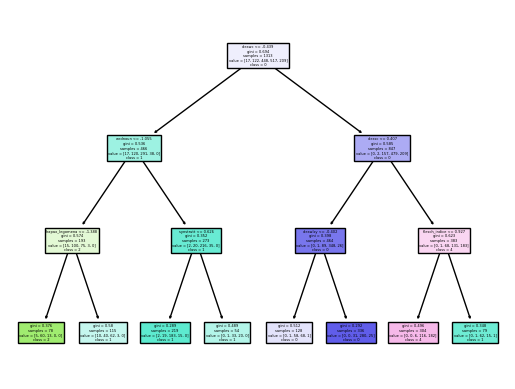

In [70]:
from sklearn import tree


tree.plot_tree(dt_clf, feature_names = feature_names, 
                    class_names=[str(cls_name) for cls_name in class_names],filled = True);

In [79]:
import numpy as np

n_nodes = dt_clf.tree_.node_count
children_left = dt_clf.tree_.children_left
children_right = dt_clf.tree_.children_right
feature = dt_clf.tree_.feature
threshold = dt_clf.tree_.threshold
values = dt_clf.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=np.around(values[i], 3)
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if {feature} <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature_names[feature[i]].upper(),
                threshold=threshold[i],
                right=children_right[i],
                value=np.around(values[i], 3),
            )
        )

The binary tree structure has 15 nodes and has the following tree structure:

node=0 is a split node with value=[[ 17. 122. 448. 517. 209.]]: go to node 1 if DESWC <= -0.43910881876945496 else to node 8.
	node=1 is a split node with value=[[ 17. 120. 291.  38.   0.]]: go to node 2 if WRDNOUN <= -1.0545501112937927 else to node 5.
		node=2 is a split node with value=[[ 15. 100.  75.   3.   0.]]: go to node 3 if HAPAX_LEGOMENA <= -1.387585163116455 else to node 4.
			node=3 is a leaf node with value=[[ 5. 60. 13.  0.  0.]].
			node=4 is a leaf node with value=[[10. 40. 62.  3.  0.]].
		node=5 is a split node with value=[[  2.  20. 216.  35.   0.]]: go to node 6 if SYNSTRUTT <= 0.6264251470565796 else to node 7.
			node=6 is a leaf node with value=[[  2.  19. 183.  15.   0.]].
			node=7 is a leaf node with value=[[ 0.  1. 33. 20.  0.]].
	node=8 is a split node with value=[[  0.   2. 157. 479. 209.]]: go to node 9 if DESSC <= 0.4074804335832596 else to node 12.
		node=9 is a split node wit

### Análise

### LIME

In [87]:
import lime
from lime import lime_text
import lime.lime_tabular as lime_tb


lime_explainer = lime_tb.LimeTabularExplainer(X_train, feature_names =     
                                 feature_names,  class_names=class_names, 
                                 mode = 'classification')

In [99]:
idx = 50

predicted_score = rf_clf.predict([X_test[idx]])[0]

lexp = lime_explainer.explain_instance(X_test[idx], rf_clf.predict_proba, 
                        num_features=len(feature_names), 
                        labels= (1, predicted_score, ) )
print("Predicted score", predicted_score)
print('Document id: %d' % idx)
print('True class: %s' % Y_test[idx])
lexp.as_list()


/opt/conda/envs/aibox-env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/envs/aibox-env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Predicted score 2
Document id: 50
True class: 2


[('hapax_legomena <= -1.02', 0.028273904060587777),
 ('dessc <= -0.89', 0.02364502772378562),
 ('wrdnoun <= -1.08', 0.023598877601797227),
 ('cncpos <= -0.96', 0.017287996880942662),
 ('-1.07 < deswc <= -0.36', 0.016700547799017633),
 ('drpp <= -0.09', 0.016403328645886256),
 ('wrdadj <= -0.98', 0.015049511559379378),
 ('synstrutt <= -0.84', 0.015031240510842585),
 ('wrdprp2p <= -0.03', 0.012908095424587427),
 ('despl <= -0.71', 0.00905458475715622),
 ('flesch_indice > 0.74', 0.008976777836373295),
 ('wrdprp2 <= -0.13', -0.008611764676189335),
 ('cncconfor <= -0.81', 0.00797619996925416),
 ('crfsoa <= -0.89', 0.00698553005044604),
 ('deswllt <= -0.83', 0.006959222214808813),
 ('deswlsyd <= -0.79', 0.005949032408209932),
 ('deswlltd <= -0.80', 0.005845004241478725),
 ('-0.87 < smcauswn <= -0.27', 0.005695596361586281),
 ('honore_statistics <= -0.73', 0.005437629738289129),
 ('rdfre > 0.71', 0.005159478637452667),
 ('0.04 < wrdmeac <= 0.73', 0.005159219313499144),
 ('deswlsy <= -0.81', 0

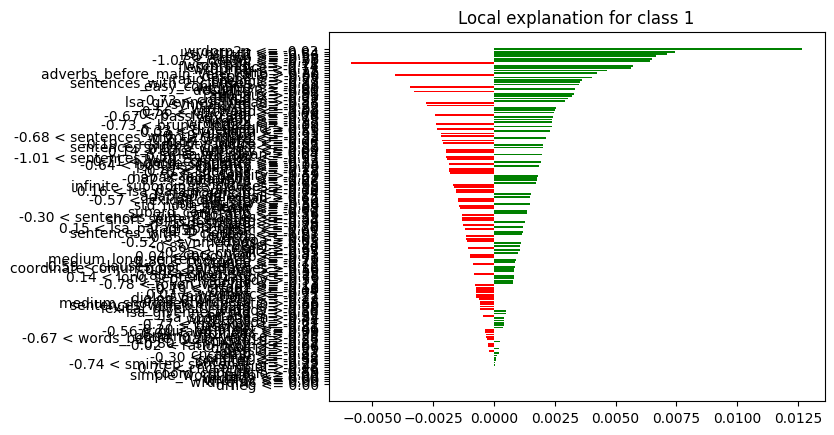

In [100]:
%matplotlib inline
fig = lexp.as_pyplot_figure(label=predicted_score)

In [102]:
lexp.show_in_notebook( labels= (predicted_score, ))

In [106]:
import shap
import matplotlib.pyplot as plt

# load JS visualization code to notebook
shap.initjs()

# Create the explainer
shap_explainer = shap.TreeExplainer(rf_clf)

shap_values = shap_explainer.shap_values(X_test)

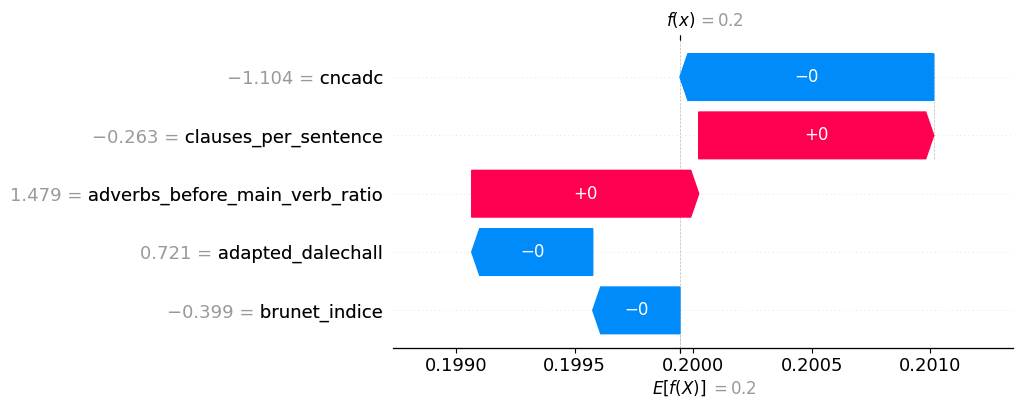

In [107]:

shap.waterfall_plot(shap.Explanation(values=shap_values[idx][0], 
                                              base_values=shap_explainer.expected_value[0], data=X_test[idx],  
                                         feature_names=feature_names))

In [75]:
from sklearn.inspection import permutation_importance
import pandas as pd

def calculate_pfi(model, x_test, y_test, feature_names):

    r = permutation_importance(model, x_test, y_test, n_repeats=30, random_state=0)

    features_df = []
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:

            print(f"{feature_names[i]:<8} "
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")
            features_df.append({
                "feature_names": feature_names[i],
                "mean": r.importances_mean[i],
                "std": r.importances_std[i]
            })


    return pd.DataFrame(features_df).set_index("feature_names")

Calculando Feature importance for model:  SVC


KeyboardInterrupt: 

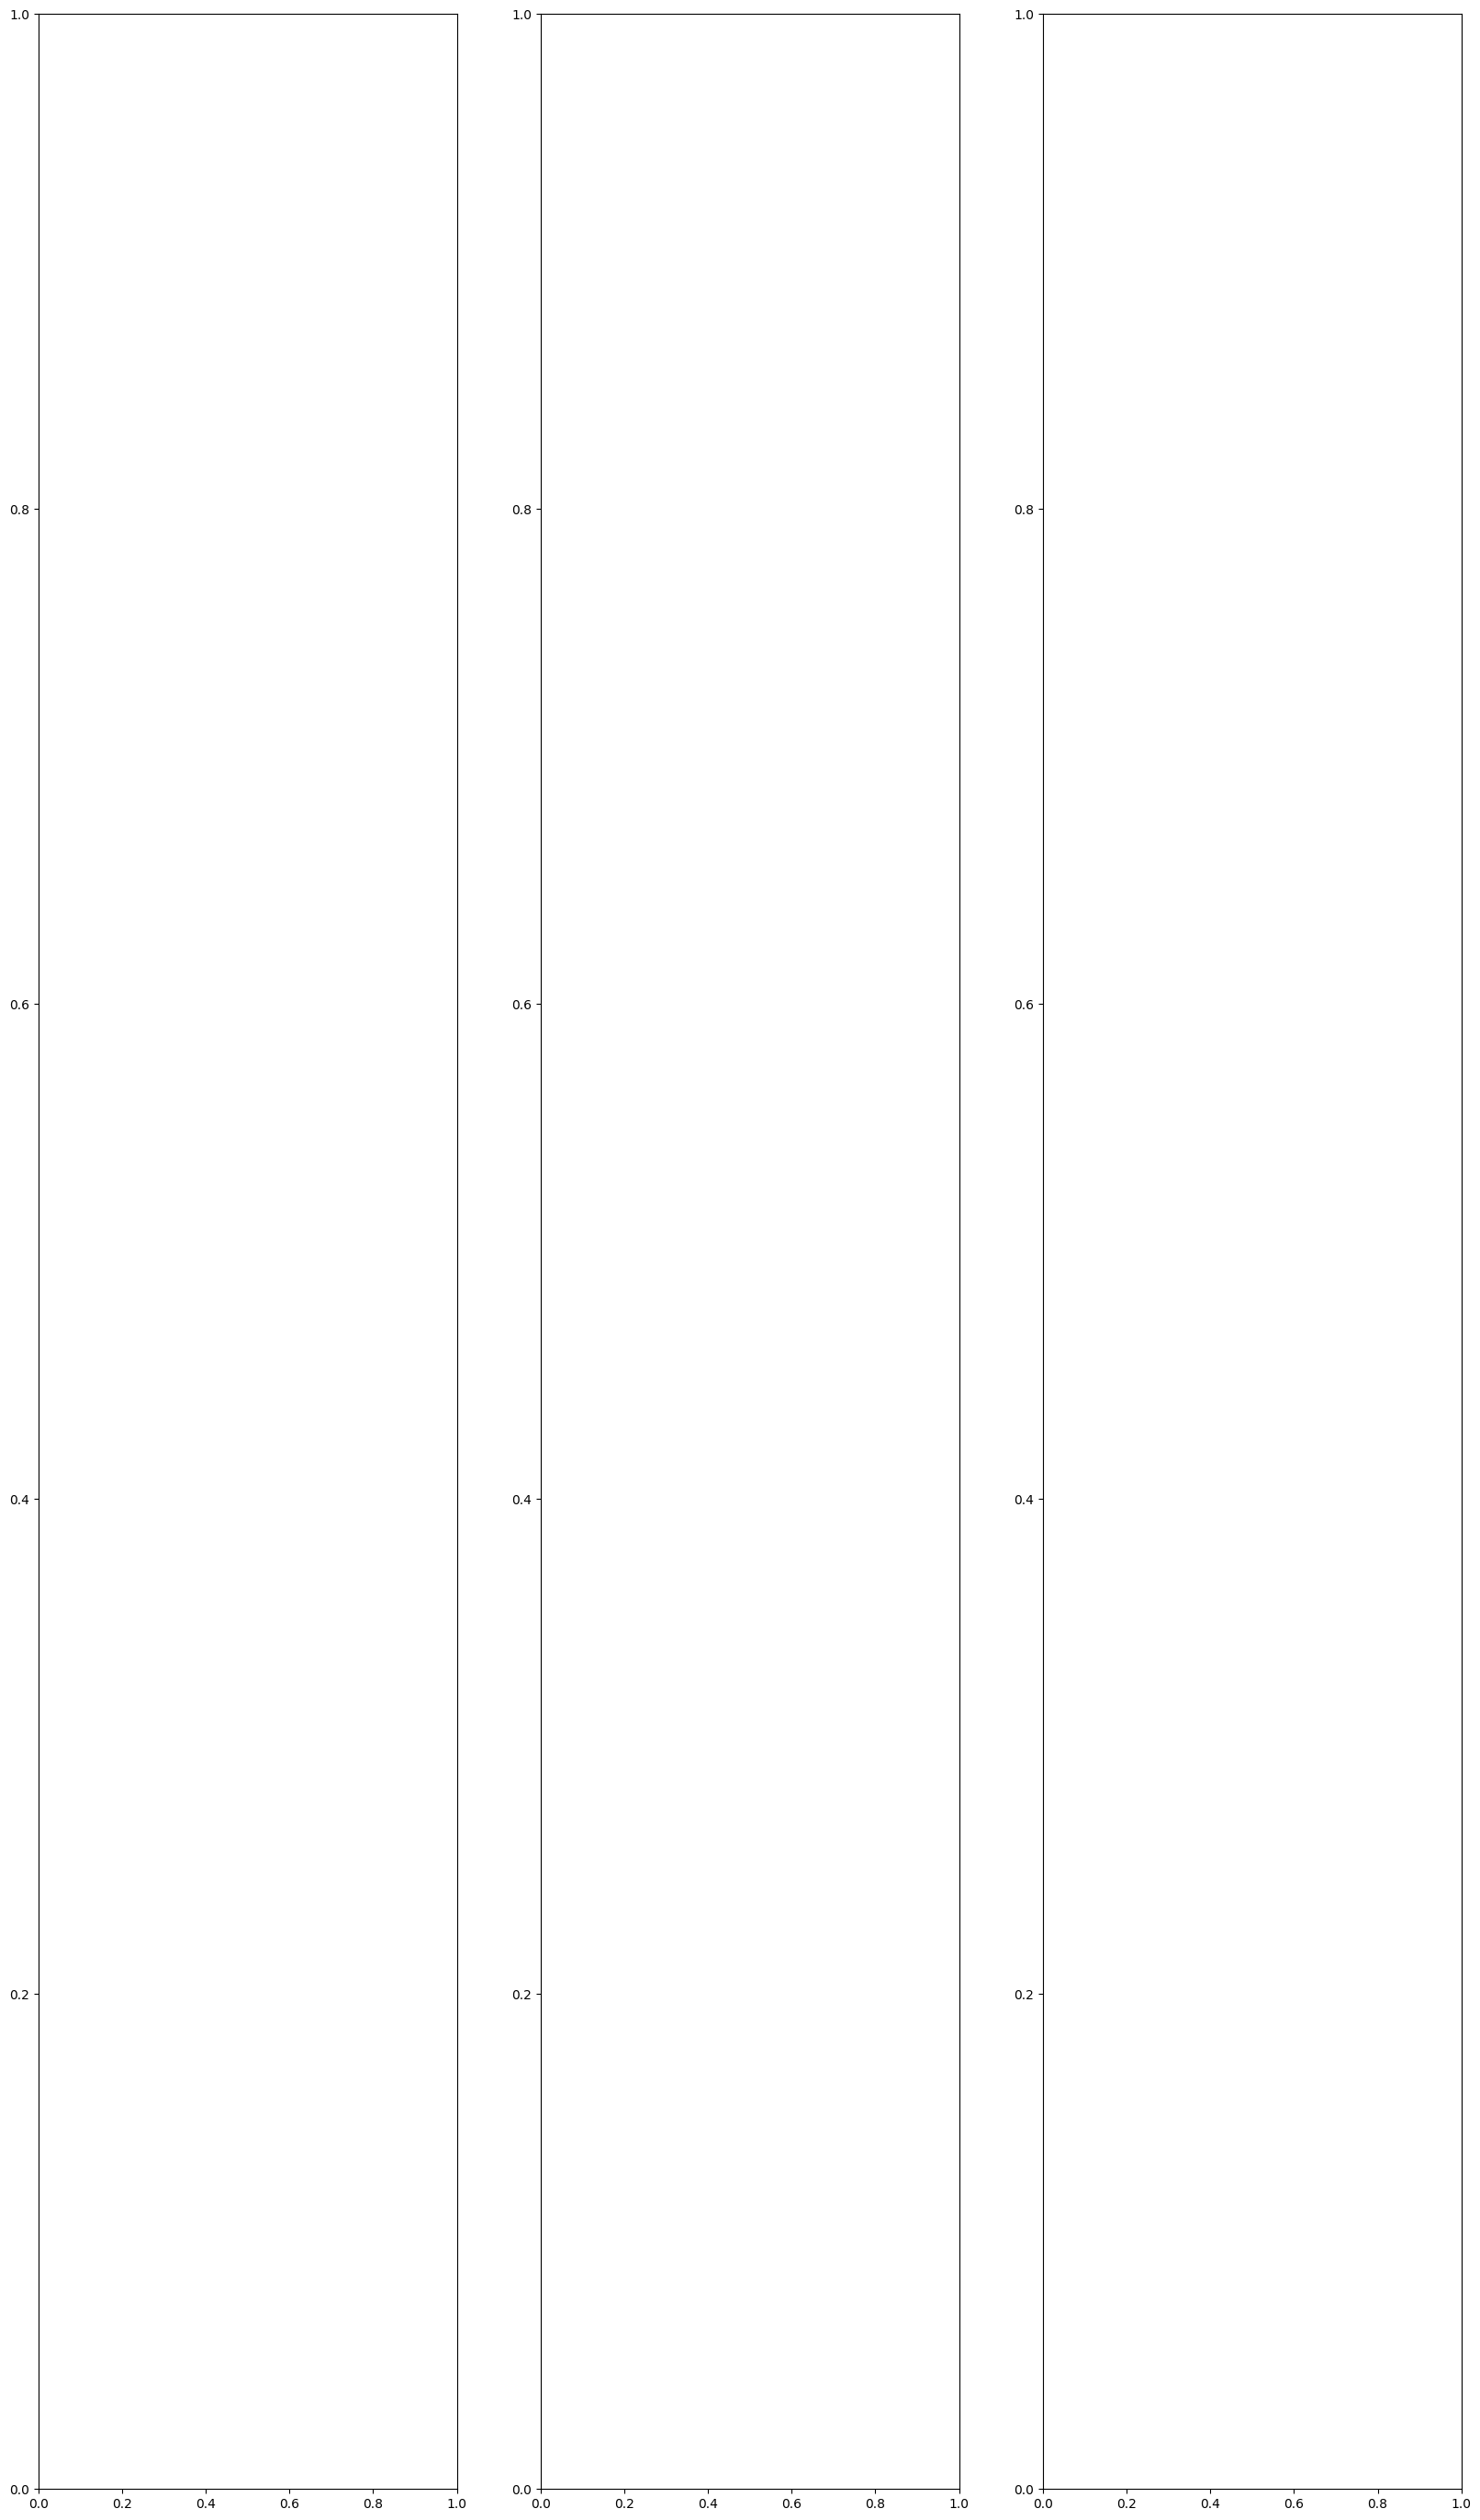

In [76]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, len(clf_list), figsize=(20,35))


fpi_per_clf = {}
for i, ml_class in enumerate(clf_list):

    ml_name = ml_class.__class__.__name__
    print("Calculando Feature importance for model: ", ml_name)
    fpi_df = calculate_pfi(ml_class, X_test, Y_test, feature_names)
    fpi_per_clf[ml_name] = fpi_df
    fpi_df.plot(kind = "barh", y = "mean", legend = False,
            title = ml_name, xerr = "std", ax=axes[i] if len(clf_list) > 1 else axes)
    print()
    print("-"*10)

### Partial Dependence Plot

Variable Importance Plot - Global Interpretation


<Figure size 640x480 with 0 Axes>

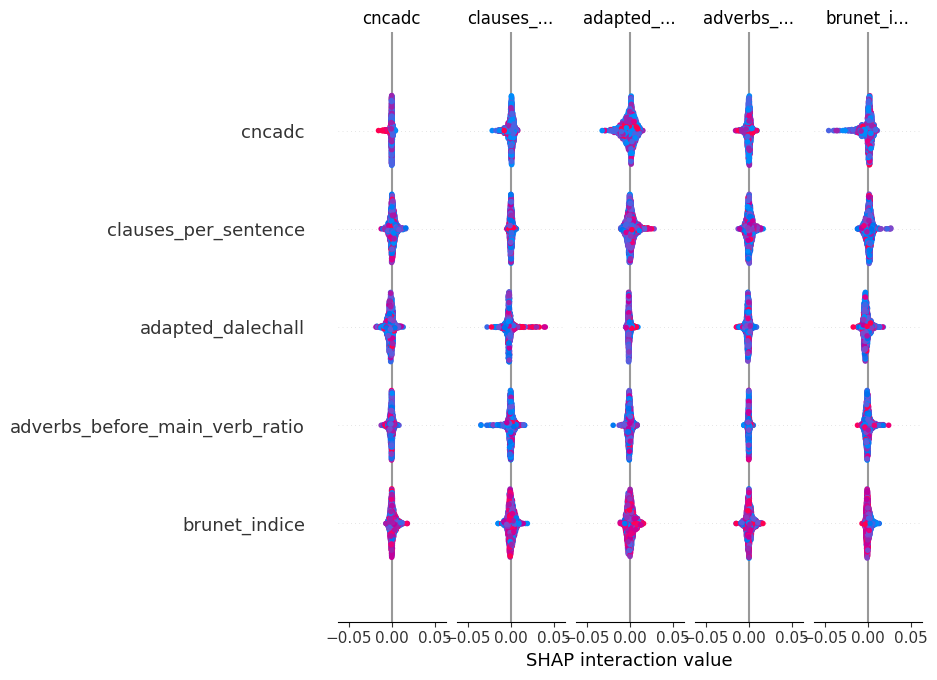

In [108]:
import matplotlib.pyplot as plt
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, X_test, class_names= class_names, feature_names = feature_names, plot_type="bar")